In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global_1.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_deaths_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_recovered_global.csv


In [2]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import timeit
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#Loading Data set
data_csv = pd.read_csv("../input/ece657aw20asg4coronavirus/time_series_covid19_recovered_global.csv")

In [4]:
#dataframe conversion
data_df=pd.DataFrame(data_csv)

In [5]:
#dataframe conversion
data_df=pd.DataFrame(data_csv)

In [6]:
df=data_df.iloc[:,4:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,0,0,0,0,0,0,0,0,0,0,...,29,32,32,32,32,32,40,43,54,99
1,0,0,0,0,0,0,0,0,0,0,...,154,165,182,197,217,232,248,251,277,283
2,0,0,0,0,0,0,0,0,0,0,...,237,347,405,460,591,601,691,708,783,846
3,0,0,0,0,0,0,0,0,0,0,...,52,58,71,71,128,128,128,169,169,191
4,0,0,0,0,0,0,0,0,0,0,...,2,2,2,4,4,4,5,5,5,5


In [7]:
#checking the missing value
df.isnull().sum()

1/22/20    0
1/23/20    0
1/24/20    0
1/25/20    0
1/26/20    0
          ..
4/13/20    0
4/14/20    0
4/15/20    0
4/16/20    0
4/17/20    0
Length: 87, dtype: int64

In [8]:
# daily total number of recovery
daily_recov = df.sum(axis=0)
daily_recov.head()

1/22/20    28
1/23/20    30
1/24/20    36
1/25/20    39
1/26/20    52
dtype: int64

In [9]:
#changing the day time formal
daily_recov.index=pd.to_datetime(daily_recov.index)
daily_recov.head()

2020-01-22    28
2020-01-23    30
2020-01-24    36
2020-01-25    39
2020-01-26    52
dtype: int64

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Cumulative daily recovery')

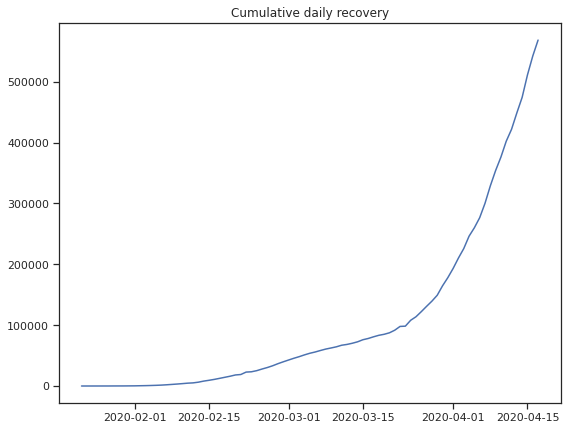

In [10]:
plt.figure(figsize=(9,7))
plt.plot(daily_recov)
plt.title("Cumulative daily recovery")

In [11]:
daily_recov=daily_recov.diff().fillna(daily_recov[0]).astype(np.int)

In [12]:
daily_recov.head()

2020-01-22    28
2020-01-23     2
2020-01-24     6
2020-01-25     3
2020-01-26    13
dtype: int64

Text(0.5, 1.0, 'Daily recovery')

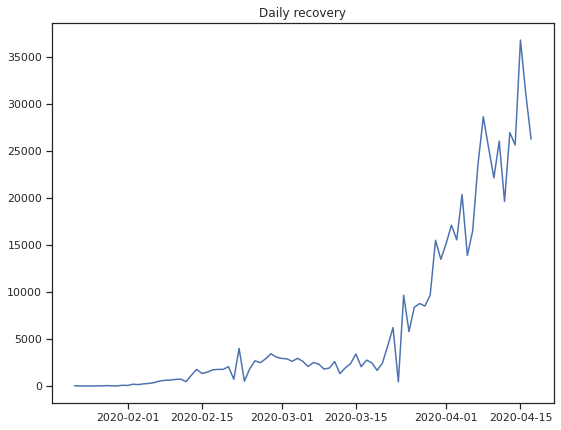

In [13]:
plt.figure(figsize=(9,7))
plt.plot(daily_recov)
plt.title("Daily recovery")

In [14]:
daily_recov=pd.DataFrame(daily_recov)
daily_recov.index.name = 'Datetime'
daily_recov
col=['Recovery_Daily']
daily_recov.columns=col

In [15]:
split_date = '2020-04-05'
train = daily_recov.loc[daily_recov.index <= split_date].copy()
test = daily_recov.loc[daily_recov.index > split_date].copy()

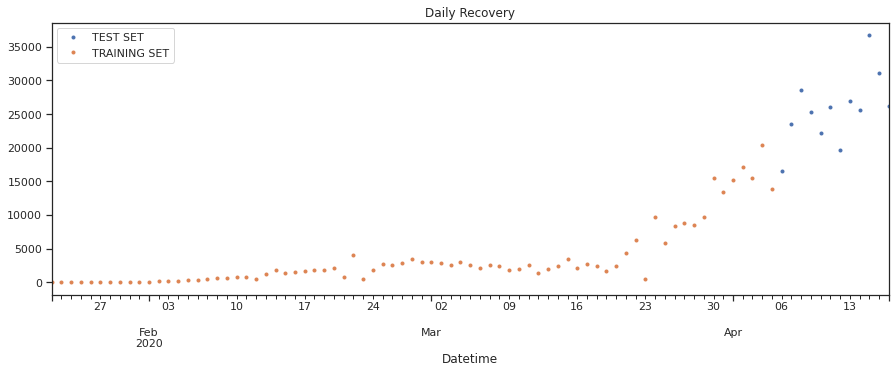

In [16]:
test \
    .rename(columns={'Recovery_Daily': 'TEST SET'}) \
    .join(train.rename(columns={'Recovery_Daily': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Daily Recovery', style='.')
plt.show()

In [17]:
# Format data for prophet model using ds and y
train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'Recovery_Daily':'y'}).head()

,ds,y
0,2020-01-22,28
1,2020-01-23,2
2,2020-01-24,6
3,2020-01-25,3
4,2020-01-26,13


In [18]:
from fbprophet import Prophet
# Setup and train model and fit
model = Prophet()
model.fit(train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'Recovery_Daily':'y'}))

In [19]:
# Predict on training set with model
test_fcst = model.predict(df=test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

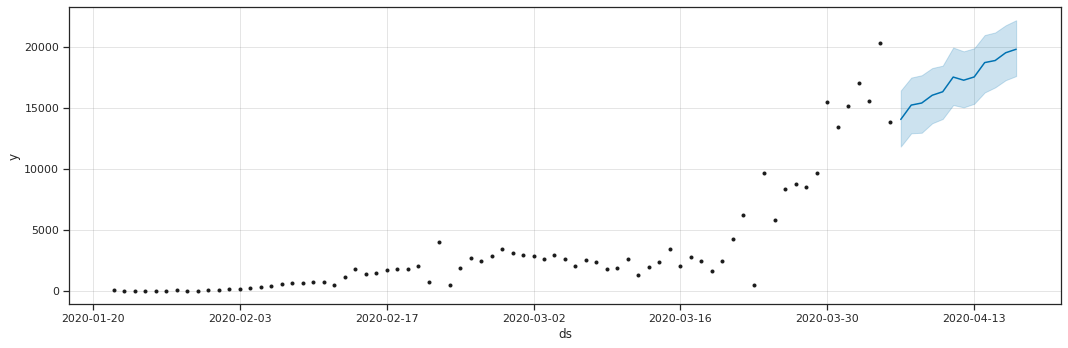

In [20]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst,
                 ax=ax)
plt.show()

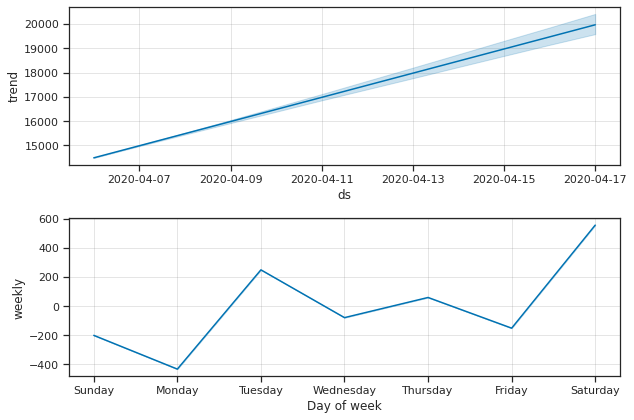

In [21]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

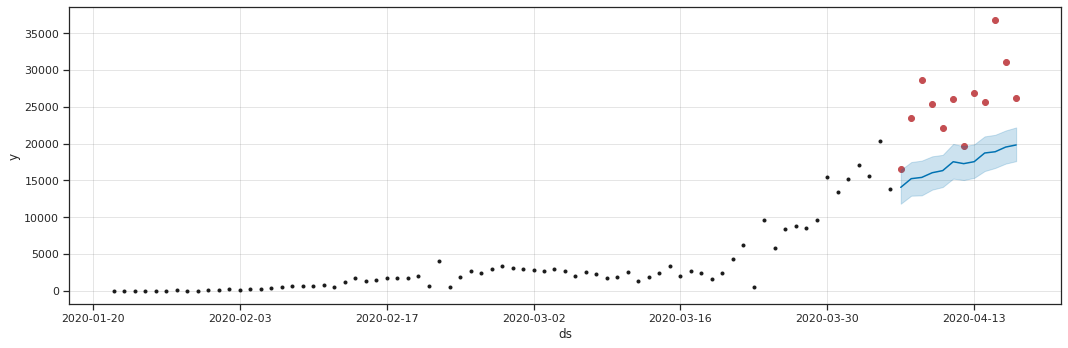

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['Recovery_Daily'], color='r')
fig = model.plot(test_fcst, ax=ax)

* Here the red dots are the actual data
* Blue line is our prediction
